<a href="https://colab.research.google.com/github/kanru-wang/coursera_generative_deep_learning/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

Use a pretrained VGG19 model as the feature extractor.

Get outputs from specific layers of the model to compute the style and content loss, then use that to update the content image.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Utilities

In [2]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image


## Download Images

In [3]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images

mkdir: cannot create directory ‘images’: File exists
image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [4]:
# set default images
content_path = f'{IMAGE_DIR}/swan.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'

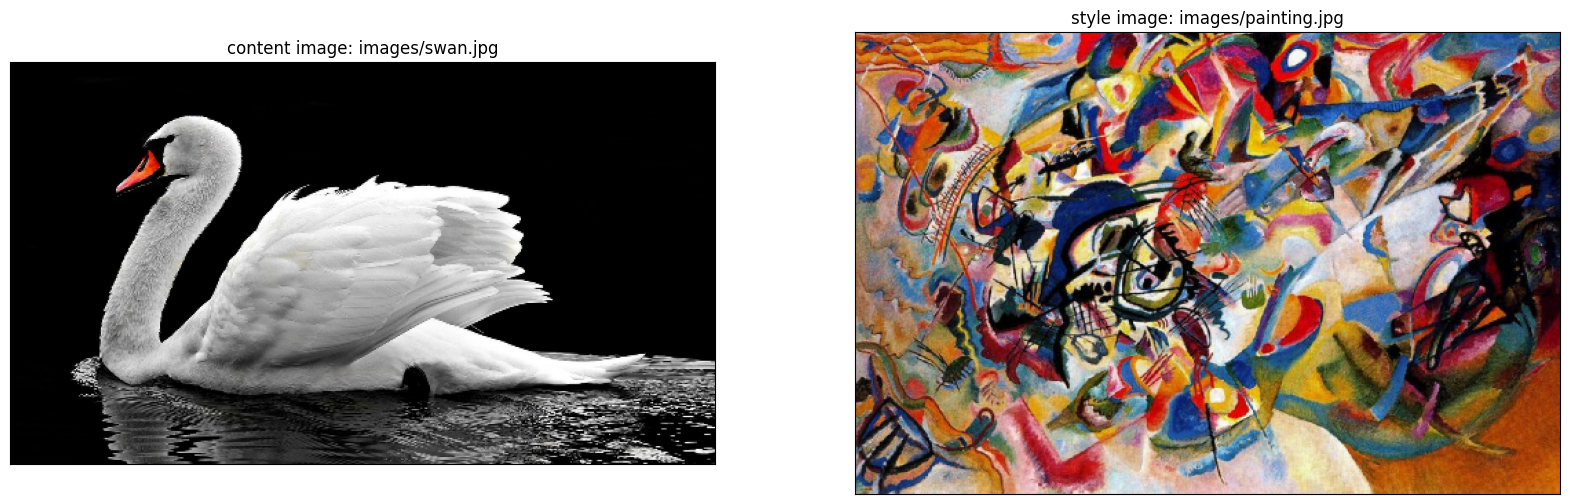

In [5]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

## Build the model 

<img src="https://drive.google.com/uc?export=view&id=1xNii3cDPob5cX8QpXPu3S3ps8s9O5X15" width="75%" height="75%"/>

Use the VGG-19 model as the feature extractor. You will feed in the style and content image and depending on the computed losses, a new image will be generated which has elements of both the content and style image. You can download a temporary copy of the model just for inspecting the layers that are available for you to use.

In [6]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Choose intermediate layers from the network to extract the style and content of the image:

- For the style layers, you will use the first layer of each convolutional block.

- For the content layer, you will use the second convolutional layer of the last convolutional block (just one layer)

In [7]:
# style layers of interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

Define your model to take the same input as the standard VGG-19 model, and output just the selected content and style layers.

In [8]:
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

Create an instance of the model using the function that you just defined.

In [9]:
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

# create a vgg-19 model
vgg = vgg_model(output_layers)
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Define the loss functions

Next, you will define functions to compute the losses required for generating the new image. These would be the:

* style loss
* content loss
* total loss (combination of style and content loss)

### Calculate style loss

The style loss is the average of the squared differences between the features and targets.

In [10]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """
  # get the average of the squared errors
  style_loss = tf.reduce_mean(tf.square(features - targets))
    
  return style_loss

### Calculate content loss

The content loss will be the sum of the squared error between the features and targets, then multiplied by a scaling factor (0.5).

In [11]:
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  
  Returns:
    content loss (scalar)
  """
  # get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    
  return content_loss

### Calculate the gram matrix

Use `tf.linalg.einsum` to calculate the gram matrix for an input tensor.
- In addition, calculate the scaling factor `num_locations` and divide the gram matrix calculation by `num_locations`.

$$ \text{num locations} = height \times width $$

In [12]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

### Get the style image features

Given the style image as input, you'll get the style features of the custom VGG model that you just created using `vgg_model()`.
- You will first preprocess the image using the given `preprocess_image()` function.
- You will then get the outputs of the vgg model.
- From the outputs, just get the style feature layers and not the content feature layer.

You can run the following code to check the order of the layers in your custom vgg model:

In [13]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

- For each style layer, calculate the gram matrix.  Store these results in a list and return it.

In [14]:
def get_style_image_features(image):  
  """ Get the style image features
  
  Args:
    image: an input image
    
  Returns:
    gram_style_features: the style features as gram matrices
  """
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image) 

  # get the outputs from the custom vgg model that you created using vgg_model()
  outputs = vgg(preprocessed_style_image) 

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS] 

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 

  return gram_style_features

### Get content image features

Now you will get the content features of an image.
- You can follow a similar process as you did with `get_style_image_features()`.
- You will not calculate the gram matrix of these features.

In [15]:
def get_content_image_features(image):
  """ Get the content image features
  
  Args:
    image: an input image
    
  Returns:
    content_outputs: the content features of the image
  """
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the vgg model
  outputs = vgg(preprocessed_content_image) 

  # get the content layers of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  # return the content layer outputs of the content image
  return content_outputs

### Calculate the style and content loss

The total loss is given by $L_{total} = \beta L_{style} + \alpha L_{content}$, where $\beta$ and $\alpha$ are weights we will give to the content and style features to generate the new image. See how it is implemented in the function below.



In [16]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
  """ Combine the style and content loss
  
  Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

  Returns:
    total_loss: the combined style and content loss

  """
    
  # sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
    
  # sum up the style and content losses
  total_loss = style_loss + content_loss 

  return total_loss

## Generate the Stylized Image

You will now define helper functions to generate the new image given the total loss.

### Calculate gradients

First is the function to calculate the gradients. The values here will be used to update the generated image to have more of the style and content features. 

*Note: If you are still in Lesson 1, please disregard the `var_weight` parameter. That will be defined and discussed in Lesson 2.*




In [17]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image) 

  return gradients

### Update the image with the style

Similar to model training, you will use an optimizer to update the original image from the computed gradients. Since we're dealing with images, we want to clip the values to the range we expect. That would be `[0, 255]` in this case.

In [18]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """

  # calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  # clip the image using the utility clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

## Style Transfer

You can now define the main loop. This will use the previous functions you just defined to generate the stylized content image. It does so incrementally based on the computed gradients and the number of epochs. Visualizing the output at each epoch is also useful so you can quickly see if the style transfer is working.

In [19]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, var_weight, content_weight, optimizer) 
    
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

### Try it out!

With all things setup, the neural style transfer is now ready to run. If you want to change the given parameters, we advise that you do so only after you have also completed Lesson 2 and its corresponding exercise at the end of this notebook.

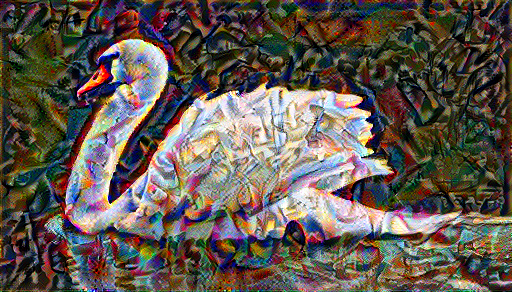

Train step: 1000


In [20]:
# define style and content weight
style_weight =  2e-2
content_weight = 1e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100)

In [21]:
# display GIF of Intermedite Outputs
GIF_PATH = 'style_transfer.gif'
gif_images = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images]
gif_path = create_gif(GIF_PATH, gif_images)
display_gif(gif_path)

## End of Lesson 1 ungraded lab

This concludes the demo for Lesson 1. Please go back to the classroom and watch Lesson 2 regarding the total variation loss. Then you can continue on to the next section below.

## Total variation loss

One downside to the implementation above is that it produces a lot of high frequency artifacts. You can see this when you plot the frequency variations of the image. We've defined a few helper functions below to do that.

In [22]:
# Plot Utilities

def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var


def plot_deltas_for_single_image(x_deltas, y_deltas, name="Original", row=1):
  plt.figure(figsize=(14,10))
  plt.subplot(row,2,1)
  plt.yticks([])
  plt.xticks([])

  clipped_y_deltas = clip_image_values(2*y_deltas+0.5, min_value=0.0, max_value=1.0)
  imshow(clipped_y_deltas, "Horizontal Deltas: {}".format(name))

  plt.subplot(row,2,2)
  plt.yticks([])
  plt.xticks([])
  
  clipped_x_deltas = clip_image_values(2*x_deltas+0.5, min_value=0.0, max_value=1.0)
  imshow(clipped_x_deltas, "Vertical Deltas: {}".format(name))


def plot_deltas(original_image_deltas, stylized_image_deltas):
  orig_x_deltas, orig_y_deltas = original_image_deltas
  
  stylized_x_deltas, stylized_y_deltas = stylized_image_deltas

  plot_deltas_for_single_image(orig_x_deltas, orig_y_deltas, name="Original")
  plot_deltas_for_single_image(stylized_x_deltas, stylized_y_deltas, name="Stylized Image", row=2)

In [23]:
# Display the frequency variations

original_x_deltas, original_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(content_image, dtype=tf.float32))

stylized_image_x_deltas, stylized_image_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(stylized_image, dtype=tf.float32))

plot_deltas((original_x_deltas, original_y_deltas), (stylized_image_x_deltas, stylized_image_y_deltas))

We can decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*. Let's define the `calculate_gradients()` function again but this time with a regularization parameter to compute the total variation loss. We've added the total variation weight as a function parameter (i.e. `var_weight`) so you can easily adjust it if you want.

In [24]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

    # add the total variation loss
    loss += var_weight*tf.image.total_variation(image)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image) 

  return gradients

## Re-run the optimization

Let's run the style transfer loop again this time taking into account the total variation loss.

In [ ]:
style_weight =  2e-2
content_weight = 1e-2
var_weight = 2

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

stylized_image_reg, display_images_reg = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=var_weight, optimizer=adam, epochs=10, steps_per_epoch=100)

In [ ]:
# Display GIF
GIF_PATH = 'style_transfer_reg.gif'
gif_images_reg = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images_reg]
gif_path_reg = create_gif(GIF_PATH, gif_images_reg)
display_gif(gif_path_reg)

In [ ]:
# Display Frequency Variations

original_x_deltas, original_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(content_image, dtype=tf.float32))

stylized_image_reg_x_deltas, stylized_image_reg_y_deltas = high_pass_x_y(
    tf.image.convert_image_dtype(stylized_image_reg, dtype=tf.float32))

plot_deltas((original_x_deltas, original_y_deltas), (stylized_image_reg_x_deltas, stylized_image_reg_y_deltas))

Notice that the variations are generally smoother with the additional parameter. Here are the stylized images again with and without regularization for comparison.

In [ ]:
show_images_with_objects([style_image, content_image, stylized_image], titles=['Style Image', 'Content Image', 'Stylized Image'])

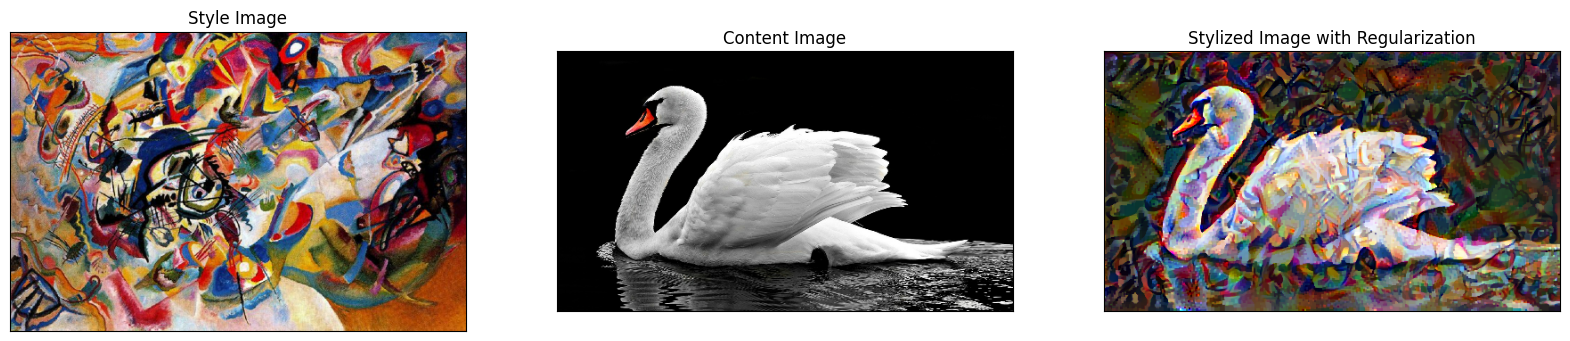

In [29]:
show_images_with_objects([style_image, content_image, stylized_image_reg], titles=['Style Image', 'Content Image', 'Stylized Image with Regularization'])